In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 146.5 MB/s eta 0:00:00


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from copy import deepcopy
import matplotlib.pyplot as plt

# =========================
# 1. Load AnnData
# =========================
h5ad_path = "/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_RNAseq_2000HVG_subset_demo.h5ad"
adata = sc.read_h5ad(h5ad_path)

print("=== AnnData Loaded ===")
print(adata)
print("obs columns:", adata.obs.columns.tolist())

# =========================
# 2. Labels: 0 = Not AD, 1 = High AD only
# =========================
path_col = "Overall AD neuropathological Change"

control_cats = ["Not AD"]
disease_cats = ["High"]   # ONLY High vs Not AD

mask_valid = adata.obs[path_col].isin(control_cats + disease_cats)
adata_sub = adata[mask_valid].copy()

print("\nCells after keeping only Not AD and High:")
print(adata_sub.n_obs)

label_map = {c: 0 for c in control_cats}
label_map.update({c: 1 for c in disease_cats})
adata_sub.obs["disease_label"] = adata_sub.obs[path_col].map(label_map).astype(int)

print("\nLabel distribution (0=Not AD, 1=High AD) in VALID subset:")
print(adata_sub.obs["disease_label"].value_counts())
# =========================
# 3. Demographic-aware downsampling (on RAW counts)
#    - keep all controls
#    - for each Sex × AgeBin × Race-combo, sample High AD up to #controls
# =========================
print("\n=== Demographic-aware downsampling (only removing from High AD) ===")

race_cols = [
    "Race (choice=White)",
    "Race (choice=Black/ African American)",
    "Race (choice=Asian)",
    "Race (choice=American Indian/ Alaska Native)",
    "Race (choice=Native Hawaiian or Pacific Islander)",
    "Race (choice=Unknown or unreported)",
    "Race (choice=Other)",
]

df = adata_sub.obs.copy()

# --- Make Sex a plain string and handle missing ---
df["Sex"] = df["Sex"].astype(str)
df.loc[df["Sex"].isin(["nan", "NaN", "<NA>"]), "Sex"] = "Unknown"

# --- Age binning ---
age = df["Age at Death"]
df["AgeBin"] = pd.cut(
    age,
    bins=[0, 60, 70, 80, 90, 130],
    labels=["<=60", "60-70", "70-80", "80-90", ">90"]
)

# Make AgeBin a string too (so groupby is easy)
df["AgeBin"] = df["AgeBin"].astype(str)

group_cols = ["Sex", "AgeBin"] + [c for c in race_cols if c in df.columns]

indices_keep_names = []

for demo_key, idx_names in df.groupby(group_cols).groups.items():
    idx_names = list(idx_names)  # obs_names in this demographic group

    labels_group = adata_sub.obs.loc[idx_names, "disease_label"]
    control_names = labels_group[labels_group == 0].index.to_numpy()  # Not AD
    disease_names = labels_group[labels_group == 1].index.to_numpy()  # High AD

    n_control = len(control_names)
    n_disease = len(disease_names)

    if n_control == 0:
        # skip groups with no controls
        continue

    # keep ALL controls
    indices_keep_names.extend(control_names)

    if n_disease > 0:
        # sample High AD up to the same number as controls (1:1 in this stratum)
        n_keep_disease = min(n_disease, n_control)
        chosen = np.random.choice(disease_names, n_keep_disease, replace=False)
        indices_keep_names.extend(chosen)

indices_keep_names = sorted(set(indices_keep_names))

print(f"Total cells BEFORE demographic downsampling: {adata_sub.n_obs}")
adata_sub = adata_sub[indices_keep_names].copy()
print(f"Total cells AFTER demographic downsampling:  {adata_sub.n_obs}")

y = adata_sub.obs["disease_label"].values
print("\nLabel distribution AFTER downsampling (0=Not AD, 1=High AD):")
print(pd.Series(y).value_counts())


# =========================
# 4.  normalization check + normalize on the DOWNSAMPLED data
# =========================
X_sample = adata_sub.X

if issparse(X_sample):
    X_sample = X_sample[:1000].toarray()
else:
    X_sample = np.asarray(X_sample[:1000])

max_val = X_sample.max()
is_integer_like = np.allclose(X_sample, np.round(X_sample))

print("\n=== Normalization Check (after downsampling) ===")
print("Sample max value in X:", max_val)
print("All values integer-like (in sample):", bool(is_integer_like))

needs_normalization = bool(is_integer_like and max_val > 50)

if needs_normalization:
    print("➡ Data looks like raw counts → applying normalize_total + log1p + scale on DOWNSAMPLED set")
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    sc.pp.log1p(adata_sub)
    sc.pp.scale(adata_sub, max_value=10)
else:
    print("➡ Data seems already normalized/log-scaled → skipping extra normalization")

# =========================
# 5. Prepare feature matrix X
# =========================
X = adata_sub.X
print("\nFinal feature matrix shape (after downsampling + normalization):", X.shape)

out_path = "/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_balanced_normalized.h5ad"

print(f"\nSaving balanced + normalized dataset to:\n{out_path}")
adata_sub.write(out_path, compression="gzip")

print(" Saved successfully!")


Using learning rate = 0.001, max_epochs = 30, patience = 5
=== AnnData Loaded ===
AnnData object with n_obs × n_vars = 1378211 × 2000
    obs: 'Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
obs columns: ['Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino']

Cells after keeping only Not AD an

/tmp/ipython-input-1195905229.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for demo_key, idx_names in df.groupby(group_cols).groups.items():


Total cells BEFORE demographic downsampling: 701490
Total cells AFTER demographic downsampling:  282999

Label distribution AFTER downsampling (0=Not AD, 1=High AD):
0    158238
1    124761
Name: count, dtype: int64

=== Normalization Check (after downsampling) ===
Sample max value in X: 2479.0
All values integer-like (in sample): True
➡ Data looks like raw counts → applying normalize_total + log1p + scale on DOWNSAMPLED set


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)



Final feature matrix shape (after downsampling + normalization): (282999, 2000)

Saving balanced + normalized dataset to:
/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_balanced_normalized.h5ad
✔ Saved successfully!


/usr/local/lib/python3.12/dist-packages/anndata/_io/utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


Using device: cuda
Using learning_rate=0.0001, max_epochs=40, patience=5, dropout=0.5, hidden=(64, 32), weight_decay=0.001

=== AnnData Loaded ===
AnnData object with n_obs × n_vars = 282999 × 2000
    obs: 'Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'disease_label'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p'
obs columns: ['Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or 

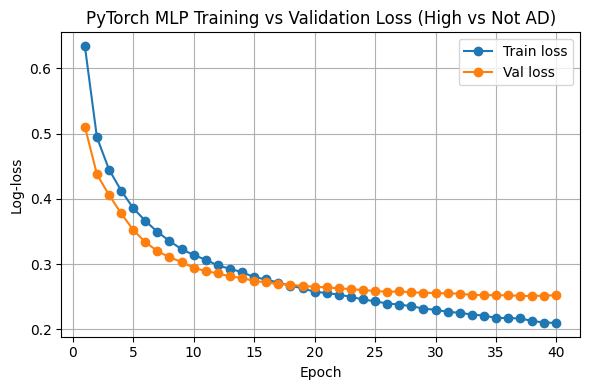

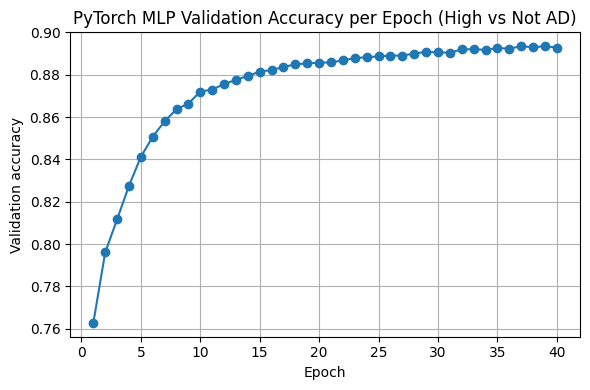

In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    log_loss,
    accuracy_score,
)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# =========================
# HYPERPARAMETERS
# =========================
learning_rate = 1e-4      # lower LR = gentler training
max_epochs    = 40
patience      = 5         # patience for early stopping (on val loss)
batch_size    = 256
hidden_sizes  = (64, 32)  # smaller model → less capacity
dropout_p     = 0.5       # strong dropout
weight_decay  = 1e-3      # L2 regularization

checkpoint_path = "/content/drive/MyDrive/Intro Genome Final project/best_mlp_high_vs_notAD.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(
    f"Using learning_rate={learning_rate}, max_epochs={max_epochs}, "
    f"patience={patience}, dropout={dropout_p}, hidden={hidden_sizes}, "
    f"weight_decay={weight_decay}"
)

# =========================
# 1. Load balanced + normalized AnnData
# =========================
h5ad_path = "/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_balanced_normalized.h5ad"
adata = sc.read_h5ad(h5ad_path)

print("\n=== AnnData Loaded ===")
print(adata)
print("obs columns:", adata.obs.columns.tolist())

if "disease_label" not in adata.obs.columns:
    raise ValueError("Expected 'disease_label' in adata.obs but it was not found.")

# =========================
# 2. Features X and labels y
# =========================
X = adata.X
y = adata.obs["disease_label"].values.astype(np.int64)  # 0 = Not AD, 1 = High AD

if issparse(X):
    X = X.toarray()
X = np.asarray(X, dtype=np.float32)

print("\nFull data shapes:")
print("X:", X.shape, " y:", y.shape)
print("Label distribution:")
print(pd.Series(y).value_counts())

# =========================
# 3. Train / Val / Test split (60 / 20 / 20)
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,      # 0.25 of 0.8 = 0.2
    random_state=42,
    stratify=y_trainval
)

print("\nShapes:")
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

print("\nLabel counts per split:")
for name, yy in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(name)
    print(pd.Series(yy).value_counts())

# =========================
# 4. Build PyTorch datasets & loaders
# =========================
X_train_t = torch.from_numpy(X_train)
X_val_t   = torch.from_numpy(X_val)
X_test_t  = torch.from_numpy(X_test)

y_train_t = torch.from_numpy(y_train)
y_val_t   = torch.from_numpy(y_val)
y_test_t  = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

# =========================
# 5. Define MLP model (GPU) with dropout
# =========================
input_dim = X.shape[1]
hidden1, hidden2 = hidden_sizes

class MLP(nn.Module):
    def __init__(self, in_dim, h1, h2, p_drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, 1)  # output logit
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, hidden1, hidden2, p_drop=dropout_p).to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

print("\nModel:")
print(model)

# =========================
# 6. Training loop with early stopping on VAL LOSS + checkpoint
# =========================
train_losses = []
val_losses   = []
val_accs     = []

best_val_loss = np.inf
best_epoch    = -1
best_state    = None
epochs_no_improve = 0

def evaluate(loader):
    """Compute loss, accuracy, probabilities, and labels on a loader."""
    model.eval()
    all_logits = []
    all_labels = []
    total_loss = 0.0
    n_samples  = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float().view(-1, 1)

            logits = model(xb)
            loss   = criterion(logits, yb)

            bs = yb.size(0)
            total_loss += loss.item() * bs
            n_samples  += bs

            all_logits.append(logits.cpu())
            all_labels.append(yb.cpu())

    avg_loss = total_loss / n_samples
    all_logits = torch.cat(all_logits).view(-1)
    all_labels = torch.cat(all_labels).view(-1)

    probs = torch.sigmoid(all_logits)
    preds = (probs >= 0.5).long()
    acc = (preds == all_labels.long()).float().mean().item()

    return avg_loss, acc, probs.numpy(), all_labels.numpy()

print("\n=== Training on GPU (if available) with Early Stopping on Validation LOSS ===")
for epoch in range(1, max_epochs + 1):
    print(f"\nEpoch {epoch}/{max_epochs}")
    model.train()
    total_train_loss = 0.0
    n_train_samples  = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()

        # Gradient clipping for extra stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        bs = yb.size(0)
        total_train_loss += loss.item() * bs
        n_train_samples  += bs

    avg_train_loss = total_train_loss / n_train_samples

    # Evaluate on validation set
    val_loss, val_acc, val_probs, val_labels_np = evaluate(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train loss: {avg_train_loss:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

    # Early stopping based on VAL LOSS (minimize)
    if val_loss < best_val_loss - 1e-4:  # small tolerance
        best_val_loss = val_loss
        best_epoch    = epoch
        best_state    = model.state_dict()
        epochs_no_improve = 0

        # Save checkpoint
        torch.save(best_state, checkpoint_path)
        print(f"  ↳ New best model found — checkpoint saved to: {checkpoint_path}")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs (best epoch: {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state)
else:
    print("\n[Warning] Early stopping never improved; using final model.")

print(f"\nBest validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
print(f"Best checkpoint is saved at: {checkpoint_path}")

# =========================
# 7. Evaluate BEST model on VAL and TEST
# =========================
# VAL
val_loss, val_acc, val_probs, val_labels_np = evaluate(val_loader)
val_preds = (val_probs >= 0.5).astype(int)

print("\n=== BEST MODEL: VAL SET PERFORMANCE ===")
print(classification_report(val_labels_np, val_preds, digits=4))
try:
    print("VAL ROC-AUC:", roc_auc_score(val_labels_np, val_probs))
except ValueError:
    print("VAL ROC-AUC: could not be computed.")
print("VAL log-loss:", log_loss(val_labels_np, val_probs))
print("VAL accuracy:", val_acc)
print("VAL Confusion matrix:")
print(confusion_matrix(val_labels_np, val_preds))

# TEST
test_loss, test_acc, test_probs, test_labels_np = evaluate(test_loader)
test_preds = (test_probs >= 0.5).astype(int)

print("\n=== BEST MODEL: TEST SET PERFORMANCE ===")
print(classification_report(test_labels_np, test_preds, digits=4))
try:
    print("TEST ROC-AUC:", roc_auc_score(test_labels_np, test_probs))
except ValueError:
    print("TEST ROC-AUC: could not be computed.")
print("TEST log-loss:", log_loss(test_labels_np, test_probs))
print("TEST accuracy:", test_acc)
print("TEST Confusion matrix:")
print(confusion_matrix(test_labels_np, test_preds))

# =========================
# 8. Training curves
# =========================
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses, marker='o', label="Train loss")
plt.plot(epochs_range, val_losses,   marker='o', label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Log-loss")
plt.title("PyTorch MLP Training vs Validation Loss (High vs Not AD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, val_accs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("PyTorch MLP Validation Accuracy per Epoch (High vs Not AD)")
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
Loaded AnnData: AnnData object with n_obs × n_vars = 282999 × 2000
    obs: 'Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'disease_label'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p'
obs columns: ['Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'disease_label']

Full data shapes

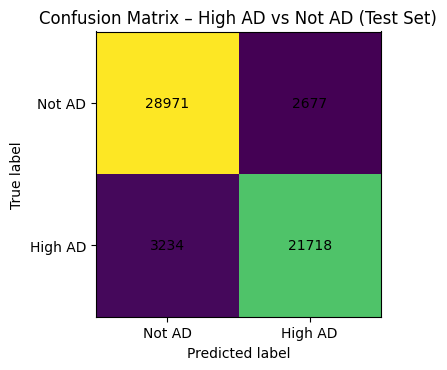


Saved confusion matrix figure to: /content/drive/MyDrive/Intro Genome Final project/confusion_matrix_high_vs_notAD.png


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# =========================
# CONFIG: paths & hyperparams (must match training)
# =========================
h5ad_path       = "/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_balanced_normalized.h5ad"
checkpoint_path = "/content/drive/MyDrive/Intro Genome Final project/best_mlp_high_vs_notAD.pt"
cm_fig_path     = "/content/drive/MyDrive/Intro Genome Final project/confusion_matrix_high_vs_notAD.png"

hidden_sizes = (64, 32)   # must match training
dropout_p    = 0.5        # must match training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# 1. Load data
# =========================
adata = sc.read_h5ad(h5ad_path)
print("Loaded AnnData:", adata)
print("obs columns:", list(adata.obs.columns))

if "disease_label" not in adata.obs.columns:
    raise ValueError("Expected 'disease_label' in adata.obs but did not find it.")

X = adata.X
y = adata.obs["disease_label"].values.astype(np.int64)  # 0 = Not AD, 1 = High AD

if issparse(X):
    X = X.toarray()
X = np.asarray(X, dtype=np.float32)

print("\nFull data shapes:")
print("X:", X.shape, " y:", y.shape)
print("Label distribution:")
print(pd.Series(y).value_counts())

# =========================
# 2. Recreate the SAME train/val/test split as training
#    (random_state must match your training script)
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,      # same as in training
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,      # 0.25 * 0.8 = 0.2 of total → 60/20/20
    random_state=42,     # same as in training
    stratify=y_trainval
)

print("\nShapes:")
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)
print("\nLabel counts per split:")
for name, yy in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(name)
    print(pd.Series(yy).value_counts())

# =========================
# 3. Build ONLY test DataLoader
# =========================
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)
test_ds   = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

# =========================
# 4. Recreate the SAME MLP architecture & load checkpoint
# =========================
input_dim = X.shape[1]
hidden1, hidden2 = hidden_sizes

class MLP(nn.Module):
    def __init__(self, in_dim, h1, h2, p_drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, 1)  # single logit for binary classification
        )

    def __call__(self, x):
        return self.net(x)

model = MLP(input_dim, hidden1, hidden2, p_drop=dropout_p).to(device)
print("\nModel:")
print(model)

if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print(f"\nLoaded best model from: {checkpoint_path}")

# =========================
# 5. Evaluate on TEST set & compute confusion matrix
# =========================
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)                      # (batch, 1)
        probs = torch.sigmoid(logits).view(-1)  # (batch,)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())

test_probs  = np.concatenate(all_probs)
test_labels = np.concatenate(all_labels)
test_preds  = (test_probs >= 0.5).astype(int)

cm = confusion_matrix(test_labels, test_preds)
print("\n=== TEST SET PERFORMANCE (loaded model) ===")
print(classification_report(test_labels, test_preds, digits=4))
print("TEST ROC-AUC:", roc_auc_score(test_labels, test_probs))
print("TEST Confusion Matrix:\n", cm)

# =========================
# 6. Plot confusion matrix (for your paper)
# =========================
classes = ["Not AD", "High AD"]

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)  # no explicit cmap per your environment

# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center")

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – High AD vs Not AD (Test Set)")

plt.tight_layout()
plt.savefig(cm_fig_path, dpi=300)
plt.show()

print(f"\nSaved confusion matrix figure to: {cm_fig_path}")


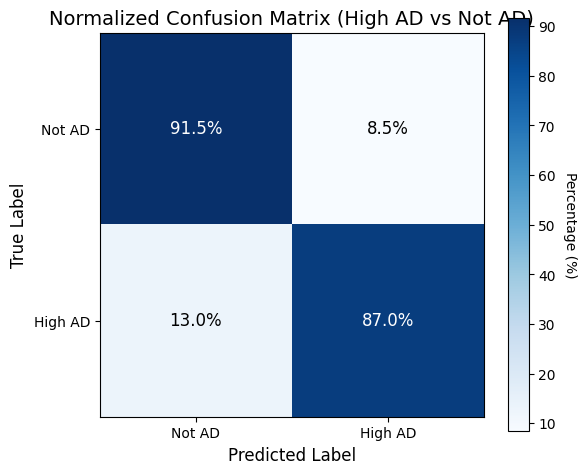

Saved normalized confusion matrix.


In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------
# Normalized confusion matrix (rows = true class)
# ----------------------------------------------
cm = confusion_matrix(test_labels, test_preds, normalize="true")
# Convert to %
cm_percent = cm * 100

classes = ["Not AD", "High AD"]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_percent, cmap="Blues")  # or 'viridis', 'magma', etc.

# Show colorbar
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Percentage (%)", rotation=270, labelpad=15)

# Annotate each cell with the percentage
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        text = f"{cm_percent[i, j]:.1f}%"
        ax.text(j, i, text,
                ha="center", va="center",
                color="black" if cm_percent[i, j] < 50 else "white",
                fontsize=12,
        )

# Axis labels & ticks
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.set_title("Normalized Confusion Matrix (High AD vs Not AD)", fontsize=14)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Intro Genome Final project/confusion_matrix_normalized.png", dpi=300)
plt.show()

print("Saved normalized confusion matrix.")


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

# ========= Paths & hyperparams must match training =========
h5ad_path       = "/content/drive/MyDrive/Intro Genome Final project/SEAAD_MTG_2000HVG_High_vs_NotAD_balanced_normalized.h5ad"
checkpoint_path = "/content/drive/MyDrive/Intro Genome Final project/best_mlp_high_vs_notAD.pt"

input_dim   = 2000          # number of HVGs
hidden1, hidden2 = (64, 32) # MUST match training
dropout_p   = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ========= Define the same MLP as in training =========
class MLP(nn.Module):
    def __init__(self, in_dim, h1, h2, p_drop=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, hidden1, hidden2, p_drop=dropout_p).to(device)

# ========= Load checkpoint =========
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Loaded best model from:", checkpoint_path)

# ========= Load AnnData =========
adata = sc.read_h5ad(h5ad_path)
print("AnnData:", adata)

X = adata.X
y = adata.obs["disease_label"].values.astype(np.int64)  # 0 = Not AD, 1 = High AD

if issparse(X):
    X = X.toarray()
X = np.asarray(X, dtype=np.float32)

print("X shape:", X.shape, " y shape:", y.shape)

# Use the same split seed as training so it matches (0 and 42)
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

gene_names = adata.var_names.to_numpy()


Using device: cuda
Loaded best model from: /content/drive/MyDrive/Intro Genome Final project/best_mlp_high_vs_notAD.pt
AnnData: AnnData object with n_obs × n_vars = 282999 × 2000
    obs: 'Overall AD neuropathological Change', 'Age at Death', 'Sex', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'disease_label'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p'
X shape: (282999, 2000)  y shape: (282999,)
Train: (169799, 2000) Val: (56600, 2000) Test: (56600, 2000)


In [5]:
from torch.utils.data import DataLoader, TensorDataset

def metric_on_Xy(X_np, y_np, batch_size=512):
    """Compute ROC-AUC on given data using current model."""
    ds = TensorDataset(torch.from_numpy(X_np), torch.from_numpy(y_np))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().view(-1).numpy()
            all_probs.append(probs)
            all_labels.append(yb.numpy())

    probs  = np.concatenate(all_probs)
    labels = np.concatenate(all_labels)
    return roc_auc_score(labels, probs), probs, labels

# ---------- Use a subset of validation data for speed ----------
max_cells_for_importance = 10000
n_val = X_val.shape[0]
rng = np.random.default_rng(0)

if n_val > max_cells_for_importance:
    idx_sub = rng.choice(n_val, max_cells_for_importance, replace=False)
    X_val_sub = X_val[idx_sub].copy()
    y_val_sub = y_val[idx_sub].copy()
else:
    X_val_sub = X_val.copy()
    y_val_sub = y_val.copy()

print("Using subset for permutation importance:", X_val_sub.shape)

# ---------- Baseline ROC-AUC ----------
baseline_auc, _, _ = metric_on_Xy(X_val_sub, y_val_sub)
print("Baseline ROC-AUC on val subset:", baseline_auc)

# ---------- Permutation importance ----------
n_features = X_val_sub.shape[1]
perm_importances = np.zeros(n_features, dtype=np.float32)

for j in range(n_features):
    X_perm = X_val_sub.copy()
    rng.shuffle(X_perm[:, j])  # shuffle gene j across cells
    auc_j, _, _ = metric_on_Xy(X_perm, y_val_sub)
    perm_importances[j] = baseline_auc - auc_j

    if (j+1) % 200 == 0 or j == n_features - 1:
        print(f"Processed {j+1}/{n_features} features...")

# ---------- Rank genes by importance ----------
order = np.argsort(perm_importances)[::-1]  # descending
top_genes_perm = gene_names[order]
top_scores_perm = perm_importances[order]

df_perm = pd.DataFrame({
    "gene": top_genes_perm,
    "perm_auc_drop": top_scores_perm
})

print("\nTop 20 genes by permutation importance:")
print(df_perm.head(20))

# Save to CSV
out_perm = "/content/drive/MyDrive/Intro Genome Final project/perm_importance_high_vs_notAD.csv"
df_perm.to_csv(out_perm, index=False)
print("\nSaved permutation importance to:", out_perm)


Using subset for permutation importance: (10000, 2000)
Baseline ROC-AUC on val subset: 0.9607382663036258
Processed 200/2000 features...
Processed 400/2000 features...
Processed 600/2000 features...
Processed 800/2000 features...
Processed 1000/2000 features...
Processed 1200/2000 features...
Processed 1400/2000 features...
Processed 1600/2000 features...
Processed 1800/2000 features...
Processed 2000/2000 features...

Top 20 genes by permutation importance:
          gene  perm_auc_drop
0       MT-ND3       0.027857
1    LINC01515       0.015023
2        USP9Y       0.006158
3       NLGN4Y       0.006028
4       TTTY14       0.005802
5        PLCG2       0.003561
6    LINC01060       0.003499
7        PWRN1       0.002560
8   AL358944.1       0.002430
9     CNTNAP3B       0.001936
10      HSPA1B       0.001719
11  AP001977.1       0.001497
12   MTRNR2L12       0.001456
13    DISC1FP1       0.001372
14      ADARB2       0.001173
15       TAFA1       0.001112
16      COL5A2       0.0011

In [3]:
!pip install captum


In [6]:
from captum.attr import IntegratedGradients

# ---------- Build Integrated Gradients explainer ----------
ig = IntegratedGradients(model)

# Baseline: all zeros (same shape as input)
baseline = torch.zeros((1, input_dim), device=device)

# Use a subset of validation samples for IG (to keep it fast)
n_ig = 2000
if X_val.shape[0] > n_ig:
    idx_ig = rng.choice(X_val.shape[0], n_ig, replace=False)
else:
    idx_ig = np.arange(X_val.shape[0])

X_ig = torch.from_numpy(X_val[idx_ig]).to(device)

print("Computing Integrated Gradients on subset:", X_ig.shape)

# ---------- Compute IG attributions ----------
# target=None because it's binary (single output neuron)
attributions = ig.attribute(
    X_ig,
    baselines=baseline,
    target=None,
    n_steps=50
)  # shape: (n_samples, input_dim)

attr_np = attributions.detach().cpu().numpy()

# We usually take mean absolute attribution per feature
ig_importance = np.mean(np.abs(attr_np), axis=0)  # shape: (input_dim,)

order_ig = np.argsort(ig_importance)[::-1]
top_genes_ig = gene_names[order_ig]
top_scores_ig = ig_importance[order_ig]

df_ig = pd.DataFrame({
    "gene": top_genes_ig,
    "integrated_gradients_importance": top_scores_ig
})

print("\nTop 20 genes by Integrated Gradients:")
print(df_ig.head(20))

out_ig = "/content/drive/MyDrive/Intro Genome Final project/ig_importance_high_vs_notAD.csv"
df_ig.to_csv(out_ig, index=False)
print("\nSaved IG importance to:", out_ig)


Computing Integrated Gradients on subset: torch.Size([2000, 2000])

Top 20 genes by Integrated Gradients:
           gene  integrated_gradients_importance
0        MT-ND3                         0.440460
1        NLGN4Y                         0.241726
2         USP9Y                         0.237492
3        TTTY14                         0.232558
4     LINC01515                         0.219852
5         PWRN1                         0.142977
6         PLCG2                         0.140228
7     MTRNR2L12                         0.131701
8      CNTNAP3B                         0.112949
9    AL358944.1                         0.109171
10        FKBP5                         0.097339
11        TAFA1                         0.096252
12       ADARB2                         0.093245
13  ADAMTS9-AS2                         0.093110
14   AP000943.2                         0.092964
15   AP001977.1                         0.092717
16       HSPA1B                         0.090584
17    LINC01

In [10]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.0.2 which is incompatible.


In [11]:
!pip install numpy

In [14]:
import shap
import numpy as np
import pandas as pd
import torch

# === Background ===
n_bg = 1000
rng = np.random.default_rng(0)

if X_train.shape[0] > n_bg:
    idx_bg = rng.choice(X_train.shape[0], n_bg, replace=False)
else:
    idx_bg = np.arange(X_train.shape[0])

background = torch.from_numpy(X_train[idx_bg]).to(device)

# === Subset validation for SHAP ===
n_shap = 1000
if X_val.shape[0] > n_shap:
    idx_shap = rng.choice(X_val.shape[0], n_shap, replace=False)
else:
    idx_shap = np.arange(X_val.shape[0])

X_shap = torch.from_numpy(X_val[idx_shap]).to(device)

# === DeepExplainer ===
explainer = shap.DeepExplainer(model, background)

raw_shap = explainer.shap_values(X_shap)

# Handle both list and array outputs
if isinstance(raw_shap, list):
    shap_vals_arr = raw_shap[0]  # shape (N, 2000, 1)
else:
    shap_vals_arr = raw_shap     # shape (N, 2000, 1)

print("Original SHAP shape:", shap_vals_arr.shape)

# === FIX: remove last dimension ===
shap_vals_arr = np.squeeze(shap_vals_arr, axis=-1)
print("After squeeze:", shap_vals_arr.shape)  # should be (N, 2000)

# === Global SHAP importance ===
shap_importance = np.mean(np.abs(shap_vals_arr), axis=0)
print("shap_importance shape:", shap_importance.shape)  # (2000,)

# === Rank genes ===
order = np.argsort(shap_importance)[::-1]
top_genes_shap = gene_names[order]
top_scores_shap = shap_importance[order]

df_shap = pd.DataFrame({
    "gene": top_genes_shap,
    "shap_importance": top_scores_shap
})

print("\nTop 20 genes by SHAP:")
print(df_shap.head(20))

# Save
out_shap = "/content/drive/MyDrive/Intro Genome Final project/shap_importance_high_vs_notAD.csv"
df_shap.to_csv(out_shap, index=False)
print("\nSaved SHAP importance to:", out_shap)


Original SHAP shape: (1000, 2000, 1)
After squeeze: (1000, 2000)
shap_importance shape: (2000,)

Top 20 genes by SHAP:
           gene  shap_importance
0        MT-ND3         0.636232
1         USP9Y         0.225343
2        NLGN4Y         0.220125
3     MTRNR2L12         0.219121
4        TTTY14         0.217232
5     LINC01515         0.195456
6      CNTNAP3B         0.179559
7    AL358944.1         0.161704
8         PLCG2         0.155586
9        ADARB2         0.151165
10   AP000943.2         0.150825
11  ADAMTS9-AS2         0.147625
12        FKBP5         0.142485
13    LINC01060         0.130158
14        PWRN1         0.129471
15        CDH13         0.128104
16   AC004158.1         0.122889
17   AC013287.1         0.119482
18       HSPA1B         0.117959
19   AC107223.1         0.109786

Saved SHAP importance to: /content/drive/MyDrive/Intro Genome Final project/shap_importance_high_vs_notAD.csv
